This notebook trains the CWW+SB4 templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict('filters/')

Load the galaxy redshift catalog, and plot the magnitudes

In [4]:
cat = Table.read('data/combined_catalog.fits')

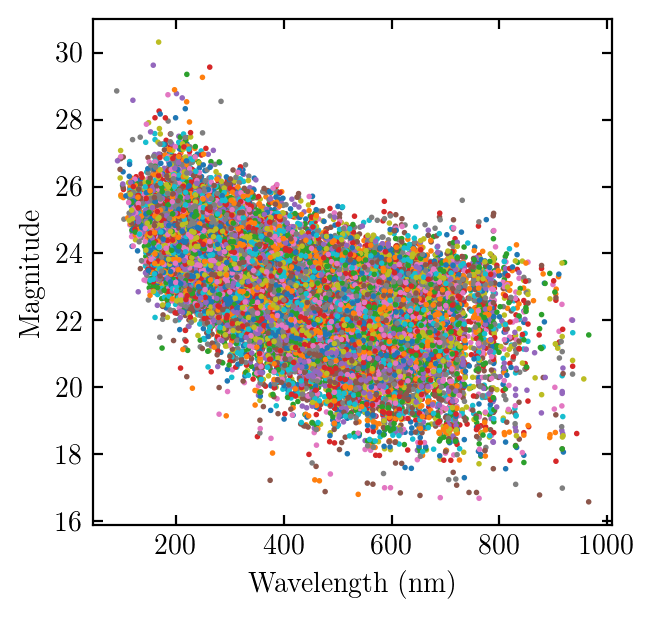

In [5]:
wavelen = get_eff_wavelen(bandpass_dict)
wavelen = np.outer(1/(1+cat['redshift']),wavelen)
mags = np.array([cat['u'],cat['g'],cat['r'],cat['i2'],
                 cat['i'],cat['z'],cat['y']]).T
colors = ['C'+str((i // 7) % 10) for i in range(len(mags)*7)]

plt.scatter(wavelen,mags,c=colors,s=1)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Magnitude")

plt.show()

Convert the magnitudes to fluxes and save everything  I need in a numpy array

In [6]:
data = np.array([cat['redshift'],
                 cat['u'],
                 cat['g'],
                 cat['r'],
                 cat['i2'],
                 cat['i'],
                 cat['z'],
                 cat['y'],
                 cat['uerr'],
                 cat['gerr'],
                 cat['rerr'],
                 cat['i2err'],
                 cat['ierr'],
                 cat['zerr'],
                 cat['yerr']])

# convert the magnitudes to fluxes
eff_wavelen = get_eff_wavelen(bandpass_dict)
data[1:8,:] = ((500/eff_wavelen)**2)[:,None] * 10**((25-data[1:8,:])/2.5)

# convert magnitude errors to flux errors
data[8:,:] *= data[1:8,:]/2.5 * np.log(10)

data = data.T

Load the CWW+SB4 templates

In [7]:
cwwsb4_templates = dict()
step = 10

x, y = np.loadtxt('templates/ssp_25Myr_z008.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['25Myr'] = sed

x, y = np.loadtxt('templates/SB2_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB2'] = sed

x, y = np.loadtxt('templates/SB3_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['SB3'] = sed

x, y = np.loadtxt('templates/Im_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Im'] = sed

x, y = np.loadtxt('templates/Scd_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Scd'] = sed

x, y = np.loadtxt('templates/Sbc_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['Sbc'] = sed

x, y = np.loadtxt('templates/El_B2004a.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
cwwsb4_templates['El'] = sed


Create training sets and plot them

In [8]:
%%time
training_sets = create_training_sets(cwwsb4_templates, data, bandpass_dict)

CPU times: user 10.8 s, sys: 47.9 ms, total: 10.8 s
Wall time: 10.8 s


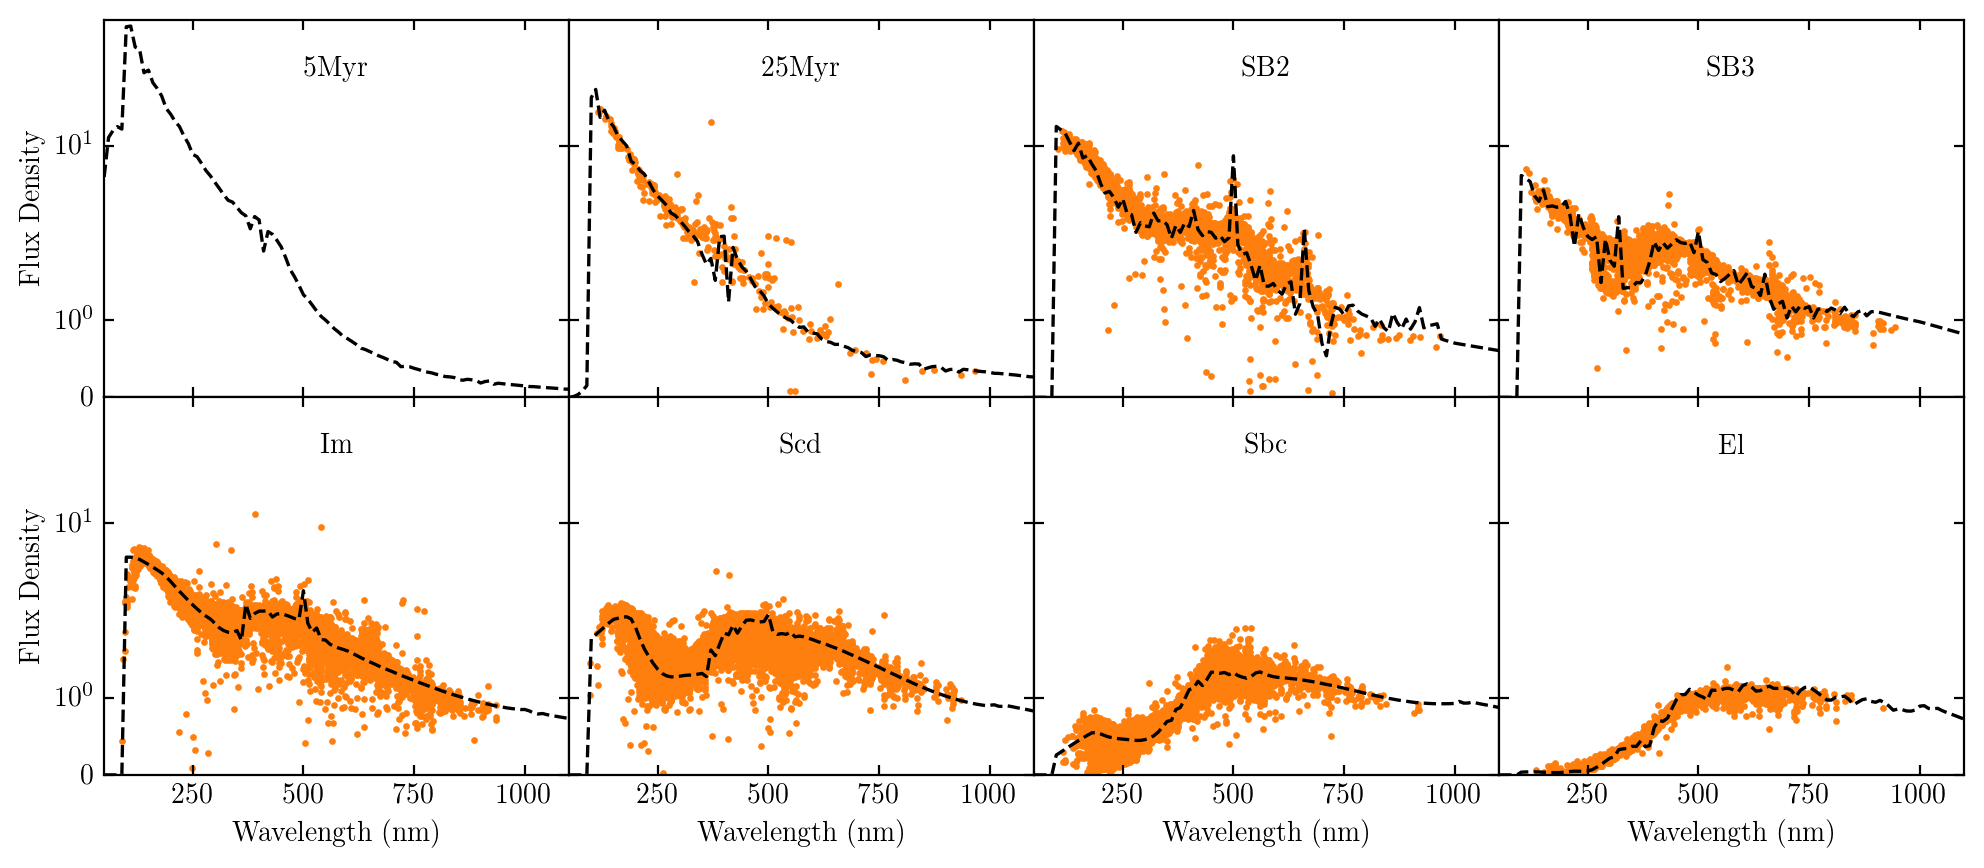

In [9]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,sharex='all',sharey='all',figsize=(12,5))

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
ax1.plot(sed.wavelen, sed.flambda, ls="--", c="k")
ax1.text(0.5,0.85,'5Myr',transform=ax1.transAxes,ha="center")

templates = ['25Myr','SB2','SB3','Im','Scd','Sbc','El']
axes = [ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for i,template in enumerate(templates):
    
    ax = axes[i]
    
    wavelen = [row[0] for row in training_sets[template]]
    fluxes = [row[1] for row in training_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,template,transform=ax.transAxes,ha="center")

plt.xlim(50,1100)
plt.ylim(0,80)
ax5.set_xlabel('Wavelength (nm)')
ax6.set_xlabel('Wavelength (nm)')
ax7.set_xlabel('Wavelength (nm)')
ax8.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Flux Density')
ax5.set_ylabel('Flux Density')
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale('symlog')

plt.show()

Now train the templates

In [10]:
%%time
trained_templates, final_sets = train_templates(cwwsb4_templates, data, bandpass_dict)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
CPU times: user 3min 29s, sys: 461 ms, total: 3min 29s
Wall time: 3min 29s


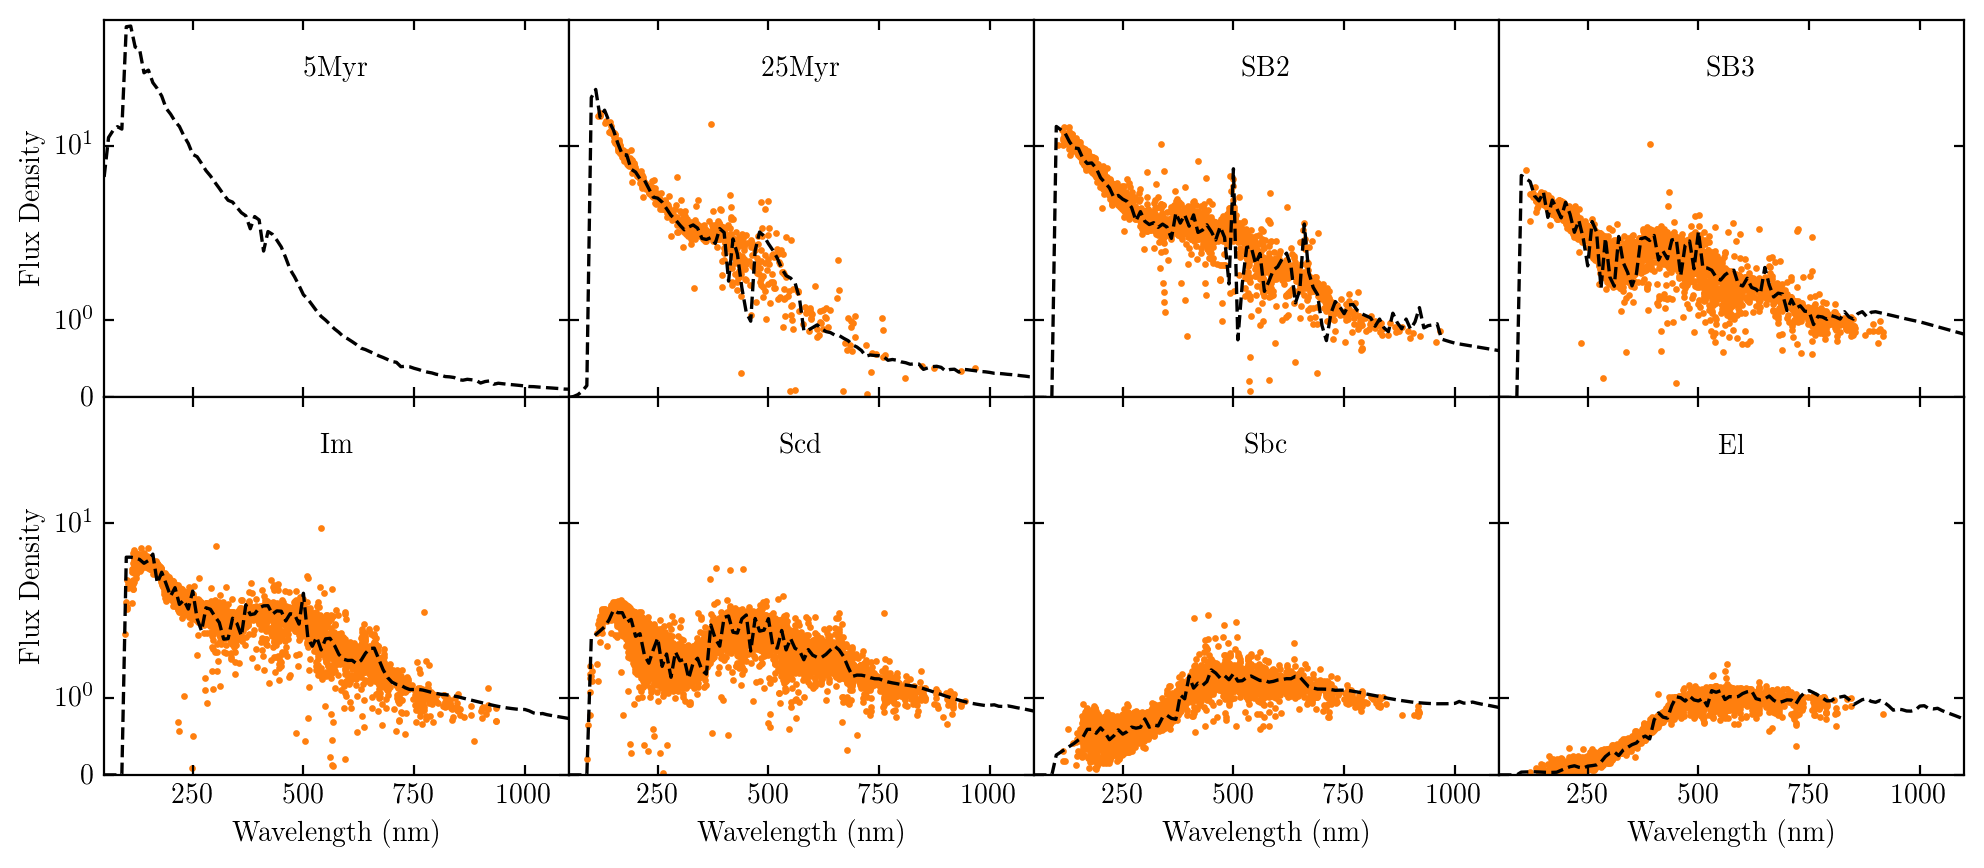

In [11]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,sharex='all',sharey='all',figsize=(12,5))

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
ax1.plot(sed.wavelen, sed.flambda, ls="--", c="k")
ax1.text(0.5,0.85,'5Myr',transform=ax1.transAxes,ha="center")

templates = ['25Myr','SB2','SB3','Im','Scd','Sbc','El']
axes = [ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for i,template in enumerate(templates):
    
    ax = axes[i]
    
    wavelen = [row[0] for row in final_sets[template]]
    fluxes = [row[1] for row in final_sets[template]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    sed = trained_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,template,transform=ax.transAxes,ha="center")

plt.xlim(50,1100)
plt.ylim(0,80)
ax5.set_xlabel('Wavelength (nm)')
ax6.set_xlabel('Wavelength (nm)')
ax7.set_xlabel('Wavelength (nm)')
ax8.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Flux Density')
ax5.set_ylabel('Flux Density')
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale('symlog')

plt.show()

Plot the trained CWW+SB4 templates with the originals

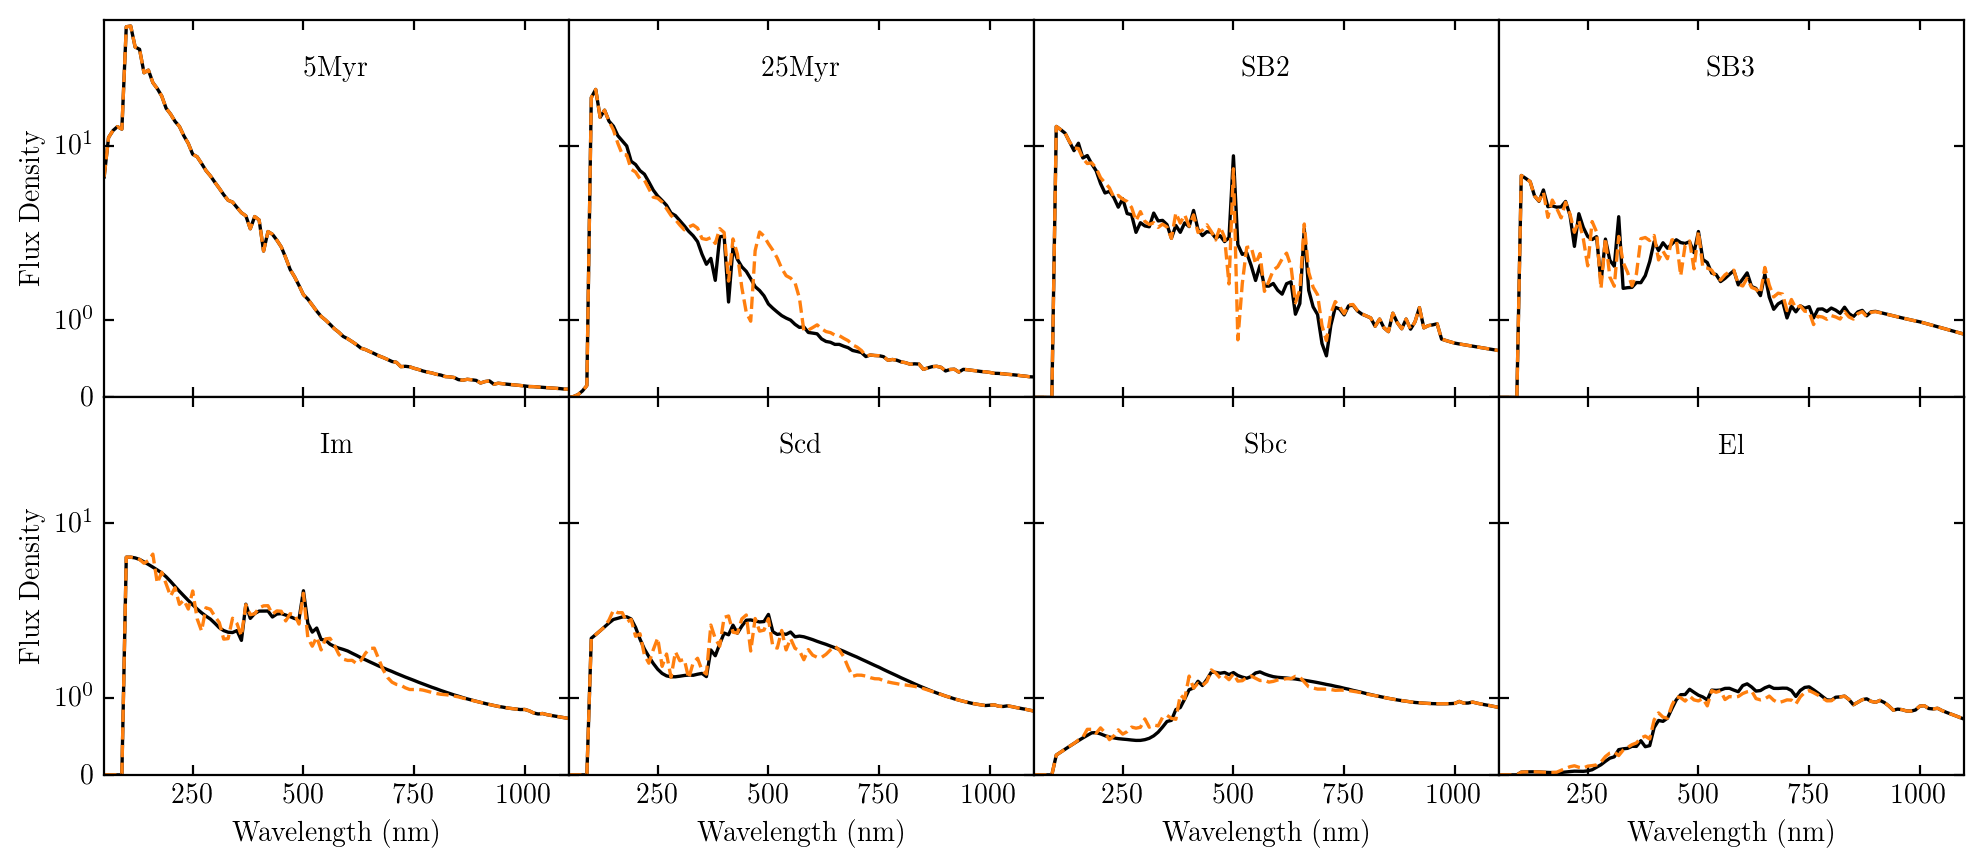

In [13]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,sharex='all',sharey='all',figsize=(12,5))

x, y = np.loadtxt('templates/ssp_5Myr_z008.sed',unpack=True)
x /= 10 # they're saved in angstroms
sed = Sed()
sed.wavelen = np.arange(50,1160,step)*1.0 # downsample
sed.flambda = np.interp(sed.wavelen,x,y)
ax1.plot(sed.wavelen, sed.flambda, ls="-", c="k")
ax1.plot(sed.wavelen, sed.flambda, ls="--", c="C1")
ax1.text(0.5,0.85,'5Myr',transform=ax1.transAxes,ha="center")

templates = ['25Myr','SB2','SB3','Im','Scd','Sbc','El']
axes = [ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for i,template in enumerate(templates):
    
    ax = axes[i]

    sed = cwwsb4_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="-", c="k")
    
    sed = trained_templates[template]
    ax.plot(sed.wavelen, sed.flambda, ls="--", c="C1")
    
    ax.text(0.5,0.85,template,transform=ax.transAxes,ha="center")

plt.xlim(50,1100)
plt.ylim(0,80)
ax5.set_xlabel('Wavelength (nm)')
ax6.set_xlabel('Wavelength (nm)')
ax7.set_xlabel('Wavelength (nm)')
ax8.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Flux Density')
ax5.set_ylabel('Flux Density')
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale('symlog')

#fig.savefig("plots/cwwsb4_beforeANDafter.pdf")
plt.show()

Save the results!

In [14]:
for template in trained_templates:
    file = open('templates/'+template+'_trained.sed','w')
    x = trained_templates[template].wavelen*10 # save as Angstroms for BPZ
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10}{1:<10}\n".format(x[i],y[i]))
    file.close()